<a href="https://colab.research.google.com/github/FrancoGalfrascoli/CSE---437-/blob/main/lab10_half_cheetah_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [15]:

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [16]:
pip install "gymnasium[mujoco]"

In [13]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [14]:
# Create the class and create a class object
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0; self.size = 0; self.cap = capacity

    def add(self, s, a, r, sp, term):
        idx = self.ptr % self.cap # Replace the oldest values if full
        self.obs[idx] = s
        self.act[idx] = a
        self.nxt[idx] = sp
        self.rew[idx] = r
        self.term[idx] = term
        self.ptr += 1
        self.size = min(self.size + 1, self.cap)

    def sample(self, batch):
        idxs = np.random.randint(0, self.size, size=batch)
        s = self.obs[idxs]
        a = self.act[idxs]
        sp = self.nxt[idxs]
        delta_s = sp - s
        x = np.concatenate([s, a], axis=-1)
        y = delta_s
        return x, y

replay = Replay(obs_dim, act_dim)



## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [17]:
def collect_random(env, replay, steps=10000, seed=42):
  obs, _ = env.reset(seed=seed)
  for t in range(steps):
    # select random action
    a = env.action_space.sample()

    # step
    next_obs, r, done, trunc, _ = env.step(a)
    term = float(done or trunc)

    # add to buffer
    replay.add(obs, a, r, next_obs, term)

    # reset if episode finished
    if done or trunc:
        obs, _ = env.reset()
    else:
        obs = next_obs

collect_random(env, replay, steps=10000, seed=42)


## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [18]:

obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# write the function to update the normalizers from the data collected in the buffer
def update_normalizers_from_buffer(replay):
    # Get samples
    s = replay.obs[:replay.size]
    a = replay.act[:replay.size]
    sp = replay.nxt[:replay.size]

    # Compute delta state
    delta_s = sp - s

    # Build input = [s, a]
    x = np.concatenate([s, a], axis=-1)

    # Update all normalizers
    obs_norm.update(s)
    inp_norm.update(x)
    targ_norm.update(delta_s)

# Example call
update_normalizers_from_buffer(replay)
print("Normalizers ready.")



Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [19]:

class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)



## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



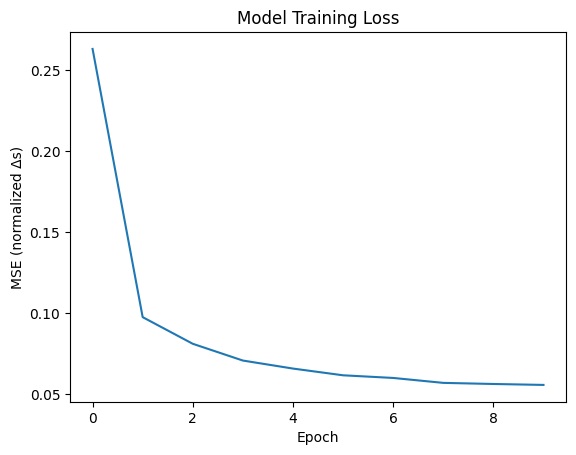

In [20]:
import torch

def train_model(model, replay, epochs=30, batch_size=256, opt=opt, scheduler=scheduler, gamma=0.8, device=None):
    # Figure out device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.train()

    # Optimizer & scheduler
    optimizer = opt
    scheduler = scheduler

    mse = nn.MSELoss()
    losses_per_epoch = []
    lrs_per_epoch = []

    # Steps per epoch (full passes over replay via random batches)
    steps_per_epoch = max(1, replay.size // batch_size)

    best_loss = float("inf")
    best_state = None
    best_epoch = -1

    for ep in range(epochs):
        total_loss = 0.0

        for _ in range(steps_per_epoch):
            # Sample batch from replay
            x_np, y_np = replay.sample(batch_size)  # unnormalized

            # Normalize and turn to tensors
            x_t = to_t(inp_norm.normalize(x_np))
            y_t = to_t(targ_norm.normalize(y_np))

            # Forward + loss
            pred = model(x_t)
            loss = mse(pred, y_t)

            # Backprop
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Epoch metrics
        epoch_loss = total_loss / steps_per_epoch
        losses_per_epoch.append(epoch_loss)

        # Record current LR (all groups share same LR typically)
        current_lr = optimizer.param_groups[0]["lr"]
        lrs_per_epoch.append(current_lr)

        # Scheduler step AFTER logging current lr
        scheduler.step()

        # Track best
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = ep

    # Load best params back into model
    if best_state is not None:
        model.load_state_dict(best_state)

    # Attach LRs for convenience (so you can plot them)
    model.train_lrs = lrs_per_epoch
    model.best_epoch = best_epoch
    model.best_loss = best_loss

    return losses_per_epoch

losses = train_model(model, replay, epochs=10, batch_size=64)
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Model Training Loss")
plt.show()


## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

In [21]:

# -------------------------------
# One-step MSE on a held-out set
# -------------------------------
replay_val = Replay(obs_dim, act_dim)
collect_random(env, replay_val, steps=5000, seed=123)

def evaluate_one_step_mse(model, replay, batch=4096, seed=123, device=None):

    if replay.size == 0:
        raise ValueError("Replay buffer is empty; collect validation data first.")

    rng = np.random.default_rng(seed)
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model = model.to(device)
    model.eval()

    N = replay.size
    idxs = rng.choice(N, size=min(batch, N), replace=False)

    s  = replay.obs[idxs]
    a  = replay.act[idxs]
    sp = replay.nxt[idxs]
    y_true = sp - s                           # unnormalized Δs

    # Normalize and predict
    x = np.concatenate([s, a], axis=-1)

    with torch.no_grad():
        x_t = to_t(inp_norm.normalize(x))
        y_pred_norm = model(x_t)
        y_pred = targ_norm.denormalize(y_pred_norm.cpu().numpy())

    mse = nn.MSELoss()
    loss = mse(to_t(y_pred), to_t(y_true)).item()

    return loss

mse_k = evaluate_one_step_mse(model, replay_val, batch=4096, seed=123)
print("Per-step MSE:", mse_k)

Per-step MSE: 0.9906716346740723


Per-step MSE: [0.         0.34561907 0.89431479 1.41782936 1.51632006 1.52004974
 1.33354262 1.3378047  1.66843817 2.00430305 1.79710294 1.49983755
 1.13448256 1.68121899 2.09146938 1.38255777 2.11462721 1.60615194
 1.78492348 1.70892564 1.96260578 2.0551638  1.90175916 1.57046858
 1.39172084 1.9818645  1.80156196 2.10338409 2.02539797 2.27390755
 1.5528412  1.6400575  1.62624848 1.61842888 1.69715686 1.77788199
 2.03940701 2.30793268 1.62293694 1.91399449 1.15032634 2.59654218
 1.36693632 2.33249094 1.61335691 1.31617969 1.92819355 2.41756831
 1.54755983 1.97980582]


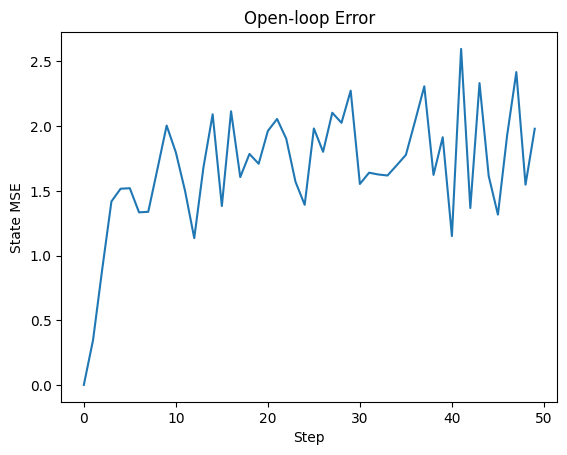

In [22]:
def evaluate_multistep_mse(env, model, k=10, n_rollouts=20, seed=123, device=None):

    rng = np.random.default_rng(seed)

    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model = model.to(device)
    model.eval()


    mse_per_step_accum = np.zeros(k, dtype=np.float64)
    count = 0

    for _ in range(n_rollouts):
        t_end = 0
        s0, _ = env.reset(seed=seed)
        actions = np.array([env.action_space.sample() for _ in range(k)], dtype=np.float32)

        # --- Ground-truth rollout from env ---
        s_true = np.zeros((k + 1, obs_dim), dtype=np.float32)
        s_true[0] = s0

        done = False
        trunc = False
        for t in range(k):
            if done or trunc:
                break
            s_next, _, done, trunc, _ = env.step(actions[t])
            s_true[t+1] = s_next
            t_end += 1

        # --- Model rollout (open-loop, same actions) ---
        s_model = np.zeros((k + 1, obs_dim), dtype=np.float32)
        s_model[0] = s0
        sm = s0.copy()
        for t in range(t_end):
            x = np.concatenate([sm[None, :], actions[t][None, :]], axis=-1)
            with torch.no_grad():
                x_t = to_t(inp_norm.normalize(x))
                dsn_norm = model(x_t)
                dsn = targ_norm.denormalize(dsn_norm.cpu().numpy())[0]
            sm = (sm + dsn).astype(np.float32)
            s_model[t+1] = sm

        # Per-step MSE

        diff = s_model[:t_end] - s_true[:t_end]   # (t_end, obs_dim)
        step_mse = np.mean(diff**2, axis=1)         # (t_end,)
        mse_per_step_accum[:t_end] += step_mse
        count += 1


    mse_per_step = mse_per_step_accum / max(count, 1)
    return mse_per_step

mse_k = evaluate_multistep_mse(env, model, k=50, n_rollouts=20, seed=123)
print("Per-step MSE:", mse_k)

# Plot
plt.plot(mse_k); plt.xlabel("Step"); plt.ylabel("State MSE"); plt.title("Open-loop Error"); plt.show()



## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



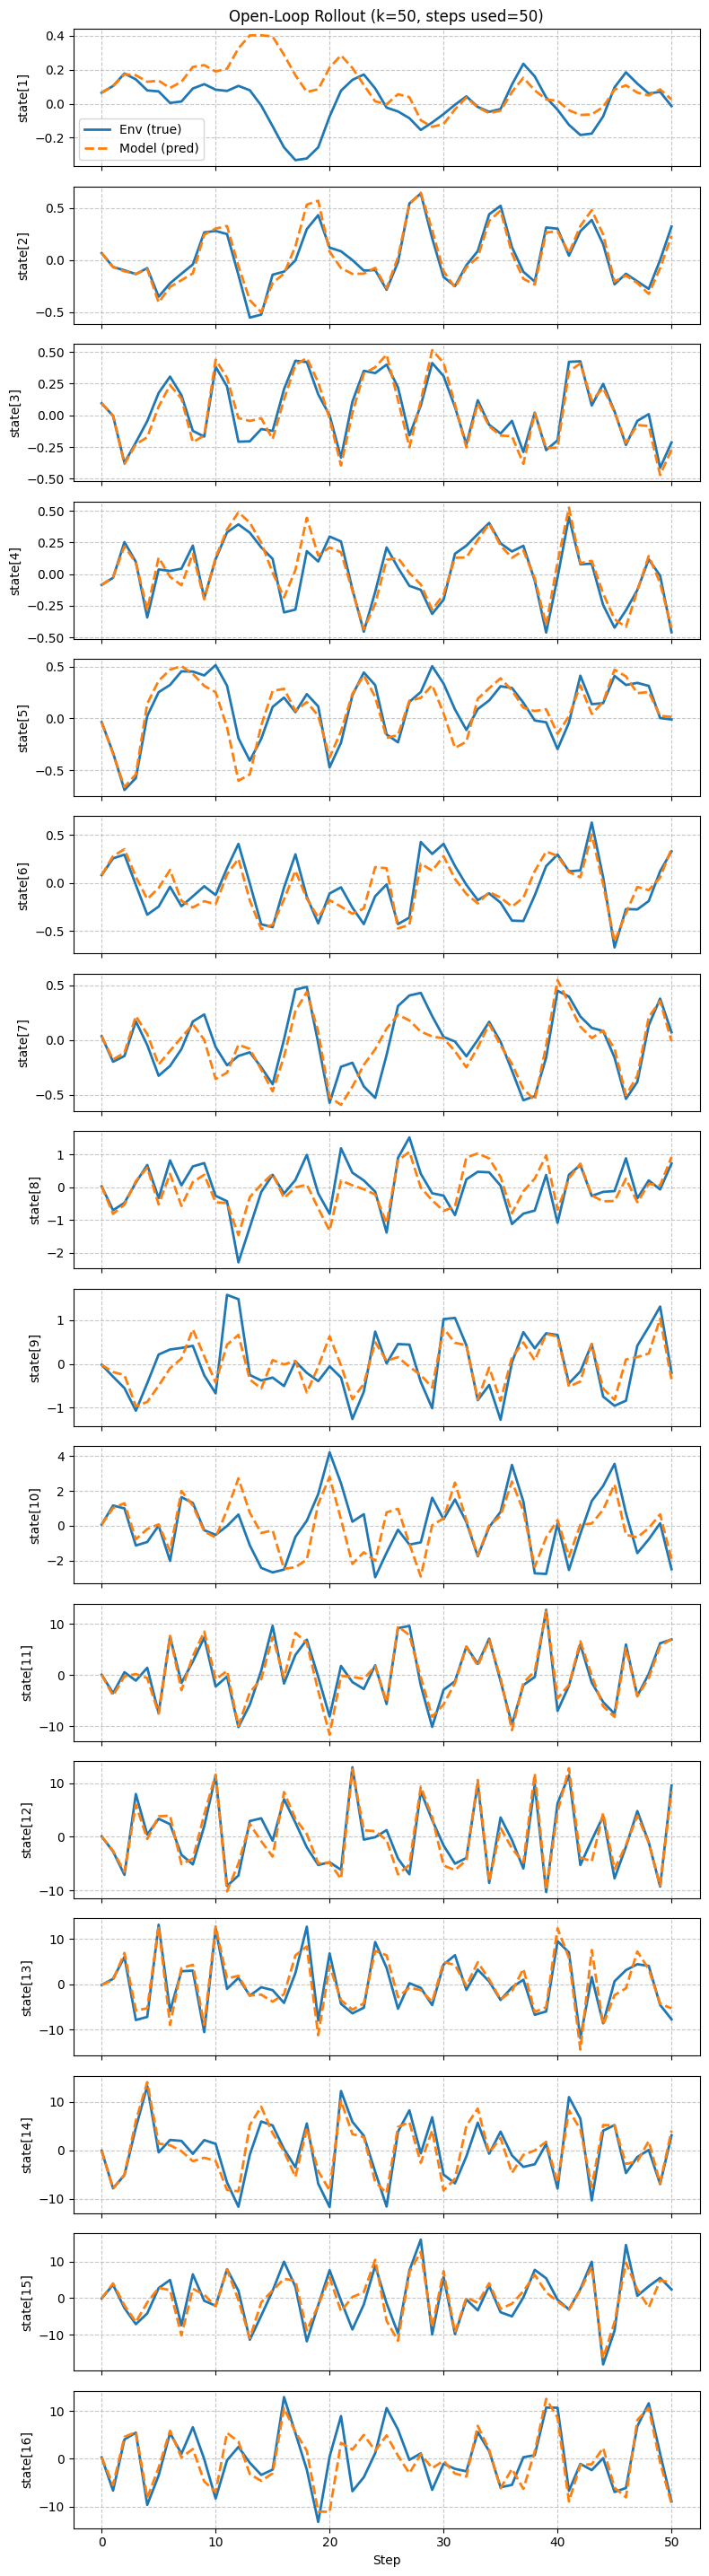

In [23]:
def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025, device=None):
    """
    Visualize a single open-loop rollout: env vs. model using the same pre-sampled actions.
    Plots state[d] vs step for each d in `dims`. Stops early if env terminates/truncates.
    Relies on global normalizers: inp_norm, targ_norm. Uses global to_t if present.
    """
    # --- setup (no grads) ---
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model = model.to(device)
    model.eval()


    # --- reset & pre-sample actions ---
    s0, _ = env.reset(seed=seed)
    s0 = s0.astype(np.float32)
    actions = np.array([env.action_space.sample() for _ in range(k)], dtype=np.float32)

    # --- ground-truth rollout (stop early on done/trunc) ---
    s_true = [s0]
    done = False
    trunc = False
    t_end = 0  # number of valid transitions
    for t in range(k):
        if done or trunc:
            break
        s_next, _, done, trunc, _ = env.step(actions[t])
        s_true.append(s_next.astype(np.float32))
        t_end += 1
    s_true = np.stack(s_true, axis=0)  # shape: (t_end+1, obs_dim)

    # --- model rollout (same actions, only t_end steps) ---
    s_model = [s0.copy()]
    sm = s0.copy()
    for t in range(t_end):
        x = np.concatenate([sm[None, :], actions[t][None, :]], axis=-1)  # (1, obs_dim+act_dim)
        with torch.no_grad():
            x_t = to_t(inp_norm.normalize(x))            # normalized [s,a]
            dsn_norm = model(x_t)                        # (1, obs_dim) normalized Δs
            dsn = targ_norm.denormalize(dsn_norm.cpu().numpy())[0]  # Δs in original units
        sm = (sm + dsn).astype(np.float32)
        s_model.append(sm)
    s_model = np.stack(s_model, axis=0)  # shape: (t_end+1, obs_dim)

    # --- plot time series for selected dims ---
    T = np.arange(s_true.shape[0])  # 0..t_end
    dims = list(dims)
    # clamp dims to valid range
    dims = [d for d in dims if 0 <= d < obs_dim]
    if len(dims) == 0:
        raise ValueError("No valid dims to plot.")

    fig, axes = plt.subplots(len(dims), 1, figsize=(8, max(2.5, 1.8 * len(dims))), sharex=True)
    if len(dims) == 1:
        axes = [axes]

    for ax, d in zip(axes, dims):
        ax.plot(T, s_true[:, d],  label='Env (true)',  linewidth=2)
        ax.plot(T, s_model[:, d], '--', label='Model (pred)', linewidth=2)
        ax.set_ylabel(f'state[{d}]')
        ax.grid(True, linestyle='--', alpha=0.7)

    axes[0].set_title(f'Open-Loop Rollout (k={k}, steps used={t_end})')
    axes[-1].set_xlabel('Step')
    axes[0].legend()
    plt.tight_layout()
    plt.show()

    return

dims = list(range(1, 17))
visualize_rollout(env, model, k=50, dims=dims)



## 9. Answer the questions :

1. How good is your model?
2. Is this training enough for planning, or do we need continual training?
3. How is this system different from the mountain car problem? Why can't we learn this in one episode?
4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.



1. This is a bit subjective but the model looks really good looking at the plots of task 6. Also, the MSE is small. To say how good it is I should compare it against other model.

2.